<a href="https://colab.research.google.com/github/mkounkel/Auriga/blob/master/Lecture_7_finished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lecture 7

Today we will be performing spectral fitting of the observed data to a template.

For simplicity, 7 templates are provided to you, all with log g=4 and [Fe/H]=0, varying only their temperature in significant intervals. Real libraries of synthetic spectra consist of thousands of templates spanning multi-dimensional space to find the one that is closes fitting to the data.

In [55]:
!pip install PyAstronomy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.3/779.3 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 7.3 MB/s eta 0:00:00
  Created wheel for PyAstronomy: filename=PyAstronomy-0.22.0-py3-none-any.whl size=557910 sha256=bd97381595ce3c3e13a3e08cf7864cbf3b3f21a6a88446dbf0d5471485514794
  Stored in directory: /root/.cache/pip/wheels/a3/53/20/11d5947fd6a452201469232799c57238f2359a090cbd90d2f0
Successfully built PyAstronomy


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from PyAstronomy.pyasl import instrBroadGaussFast

The links to the fits files with these templates are provided bellow. In these files, wavelength is specified not with CRVAL and CDELT keywords as before, but within a separate fits file stored independently, supplying the wavelength array, in Angstroms.

In [2]:
wavelength_path='https://mkounkel.domains.unf.edu/stellar/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'
m_template_path='https://mkounkel.domains.unf.edu/stellar/lte03500-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
k_template_path='https://mkounkel.domains.unf.edu/stellar/lte04500-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
g_template_path='https://mkounkel.domains.unf.edu/stellar/lte05500-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
f_template_path='https://mkounkel.domains.unf.edu/stellar/lte07000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
a_template_path='https://mkounkel.domains.unf.edu/stellar/lte09000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'
b_template_path='https://mkounkel.domains.unf.edu/stellar/lte12000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits'

We'll read in the wavelength array together, and, as it spans the bulk of the electromagnetic spectrum, we'll trim it to the range of 15000 to 17000 Angstrom, coinciding with the range of the APOGEE data.

In [47]:
hdul = fits.open(wavelength_path)
hdul.info()
wavelength=hdul[0].data
hdul.close()

a=np.where((wavelength>15000) & (wavelength<17000))[0]
wavelength=wavelength[a]

Filename: /root/.astropy/cache/download/url/ed72f0bbdfc95b5812ac84adfade6701/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (1569128,)   float64   


Read in all of the fluxes for all 6 templates into separate variables

In [48]:
hdul = fits.open(m_template_path)
m_template=hdul[0].data[a]
hdul.close()
hdul = fits.open(k_template_path)
k_template=hdul[0].data[a]
hdul.close()
hdul = fits.open(g_template_path)
g_template=hdul[0].data[a]
hdul.close()
hdul = fits.open(f_template_path)
f_template=hdul[0].data[a]
hdul.close()
hdul = fits.open(a_template_path)
a_template=hdul[0].data[a]
hdul.close()
hdul = fits.open(b_template_path)
b_template=hdul[0].data[a]
hdul.close()

The synthetic spectrum has very high resolution. We'll apply instrumental broadening, degrading resolution to R=22500 to make it better resemble the data. Follow the example below to apply broadening to all of the templates.

In [62]:
m_template_broad = instrBroadGaussFast(wavelength.flatten(), m_template.flatten(), 22500)
k_template_broad = instrBroadGaussFast(wavelength.flatten(), k_template.flatten(), 22500)
g_template_broad = instrBroadGaussFast(wavelength.flatten(), g_template.flatten(), 22500)
f_template_broad = instrBroadGaussFast(wavelength.flatten(), f_template.flatten(), 22500)
a_template_broad = instrBroadGaussFast(wavelength.flatten(), a_template.flatten(), 22500)
b_template_broad = instrBroadGaussFast(wavelength.flatten(), b_template.flatten(), 22500)

Plot the unbroadened template of an M-type star with respect to the wavelength, and the broadened template of the same type. Zoom in on a narrower range in wavelength, around 100-200 Angstroms in width

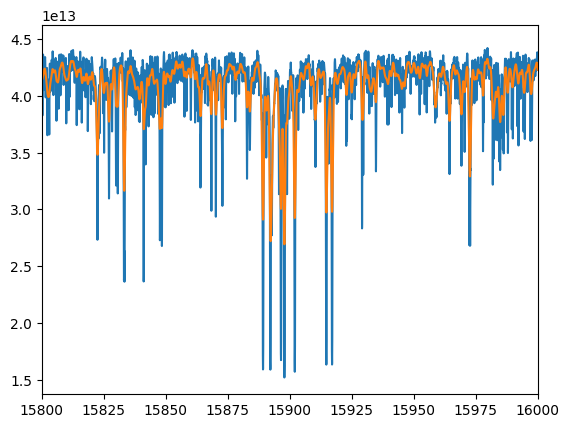

In [68]:
plt.plot(wavelength,m_template)
plt.plot(wavelength,m_template_broad)
plt.xlim(15800,16000)
plt.show()

#### Question
Compare and contrast how changing of the resolution has affected the two versions of this spectrum.

#### Answer


----
From here on we will be working with the broadened templates only.

Plot all 6 synthetic spectra as a function of wavelength on the same plot

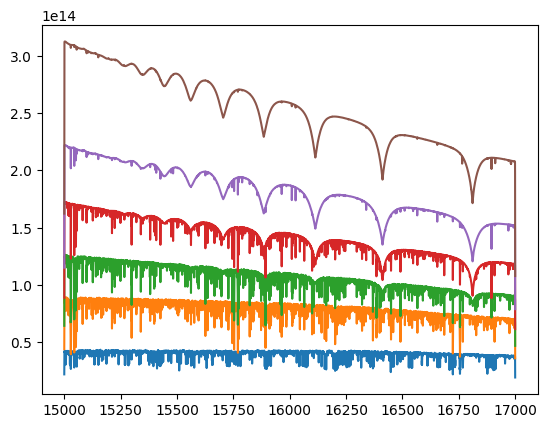

In [69]:
plt.plot(wavelength,m_template_broad)
plt.plot(wavelength,k_template_broad)
plt.plot(wavelength,g_template_broad)
plt.plot(wavelength,f_template_broad)
plt.plot(wavelength,a_template_broad)
plt.plot(wavelength,b_template_broad)
plt.show()

The code below will read in the spectrum. If you want to see why these particular extentions were chosen, look at the bottom header (stored in the extension 0).

In [82]:
spectrum_path='https://dr17.sdss.org/sas/dr17/apogee/spectro/redux/dr17/visit/lco25m/025+10/9821/57913/asVisit-dr17-9821-57913-265.fits'
hdul = fits.open(spectrum_path)
flux= hdul[1].data.flatten()
wave= hdul[4].data.flatten()
hdul.close()


Now compare flux in the spectrum with the synthetic templates. Make 6 plots, overplotting the templates and the spectrum. You might need to rescale them (e.g., dividing out the median flux of each spectrum) to make them both visible on the same range. Feel free to adjust x and y range as needed.

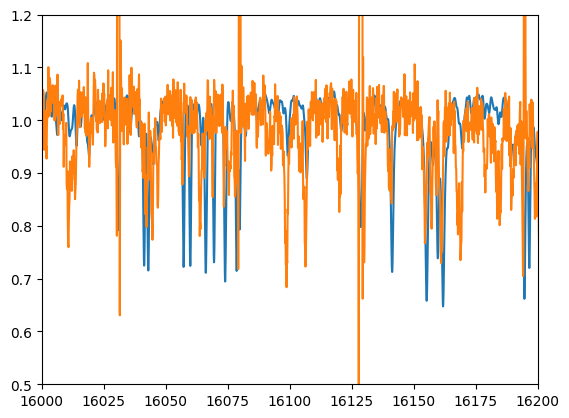

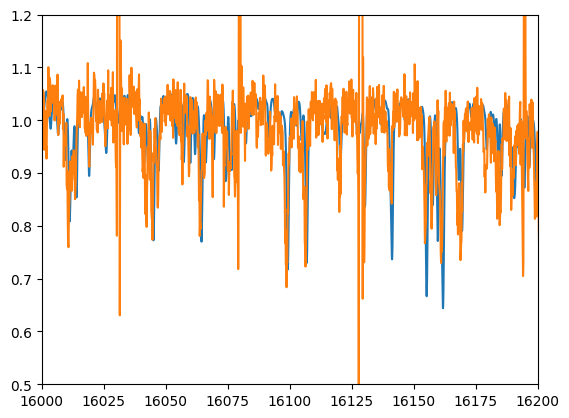

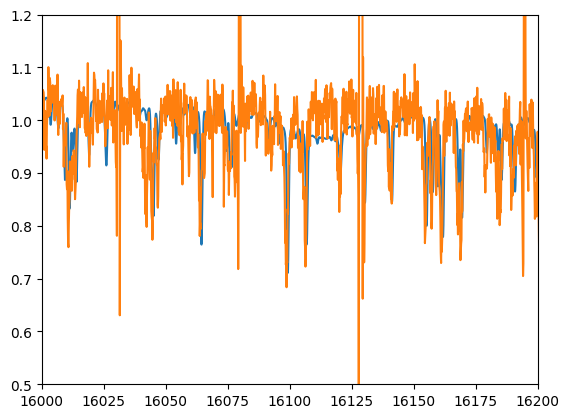

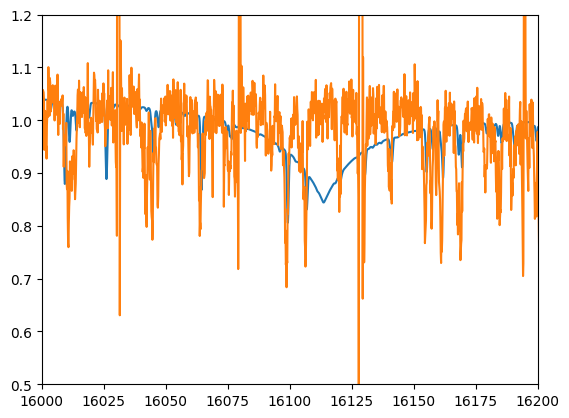

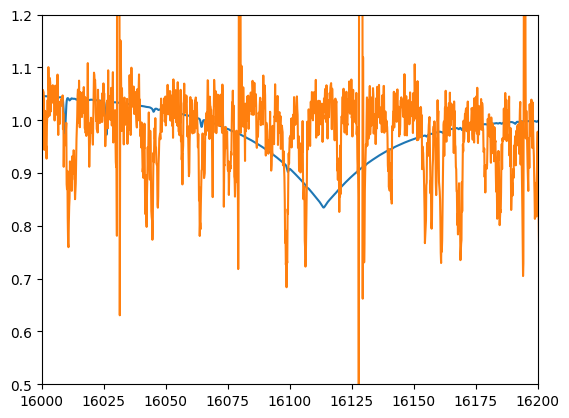

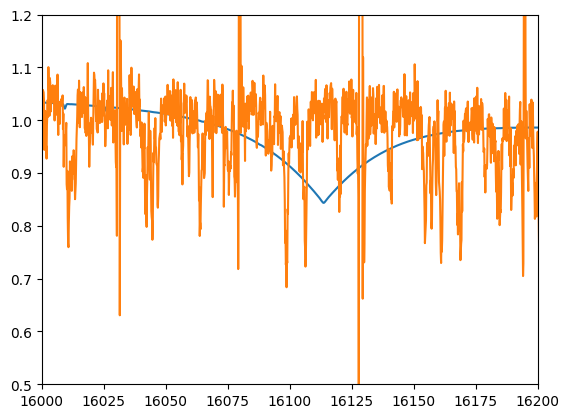

In [85]:
a,b=16000,16200
plt.plot(wavelength,m_template_broad/np.median(m_template_broad))
plt.plot(wave,flux/np.median(flux))
plt.xlim(a,b)
plt.ylim(0.5,1.2)
plt.show()
plt.plot(wavelength,k_template_broad/np.median(k_template_broad))
plt.plot(wave,flux/np.median(flux))
plt.xlim(a,b)
plt.ylim(0.5,1.2)
plt.show()
plt.plot(wavelength,g_template_broad/np.median(g_template_broad))
plt.plot(wave,flux/np.median(flux))
plt.xlim(a,b)
plt.ylim(0.5,1.2)
plt.show()
plt.plot(wavelength,f_template_broad/np.median(f_template_broad))
plt.plot(wave,flux/np.median(flux))
plt.xlim(a,b)
plt.ylim(0.5,1.2)
plt.show()
plt.plot(wavelength,a_template_broad/np.median(a_template_broad))
plt.plot(wave,flux/np.median(flux))
plt.xlim(a,b)
plt.ylim(0.5,1.2)
plt.show()
plt.plot(wavelength,b_template_broad/np.median(b_template_broad))
plt.plot(wave,flux/np.median(flux))
plt.xlim(a,b)
plt.ylim(0.5,1.2)
plt.show()

#### Question
- What spectral type is this object appears to be?
- How do you know?

#### Answer

----
Using the best template, zoom in on a narrow region, around 25 Angstrom in width. Make sure that there are obviously strong lines present in that wavelenght range. You should notice that the template and the spectrum are offset from one another in wavelength. The template spectrum is in the rest frame, the object is subject to the Doppler shift.

Using the approximate relationship between the wavelength offset and velocity, convert the wavelength array for the source to the rest frame velocity, assuming some RV. Then experiment with different values of RV to produce a reasonably close fit. You can experiment with the wavelength range to ensure consistent performance across the entire spectrum.

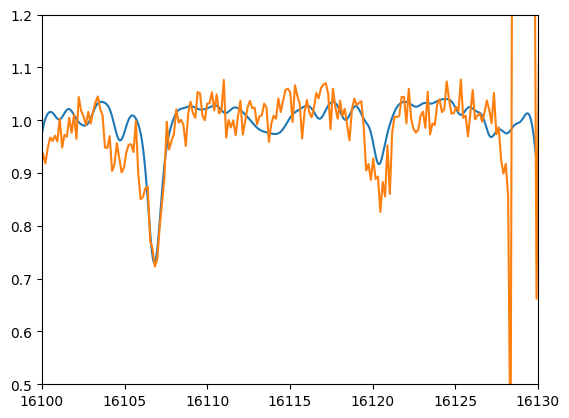

In [94]:
v=10
plt.plot(wavelength,k_template_broad/np.median(k_template_broad))
plt.plot(wave+wave*v/3e5,flux/np.median(flux))
plt.xlim(16100,16130)
plt.ylim(0.5,1.2)
plt.show()

#### Question

- Is the object blueshifted or redshifted?
- What is the radial velocity of the source?
- What is the threshold of confidence on this RV (i.e., by which value do you need to offset your best RV before the offset becomes too significant)

#### Answer

----

Repeat fitting of the template to a different spectrum, the path of which is listed below.

In [95]:
spectrum_path='https://dr17.sdss.org/sas/dr17/apogee/spectro/redux/dr17/visit/lco25m/273-28-O_TESS/11195/58774/asVisit-dr17-11195-58774-242.fits'
hdul = fits.open(spectrum_path)
flux= hdul[1].data.flatten()
wave= hdul[4].data.flatten()
hdul.close()


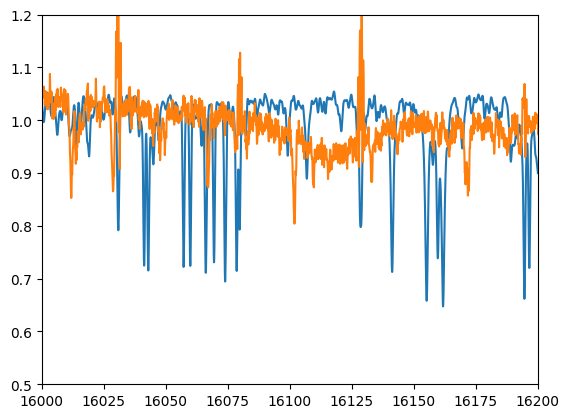

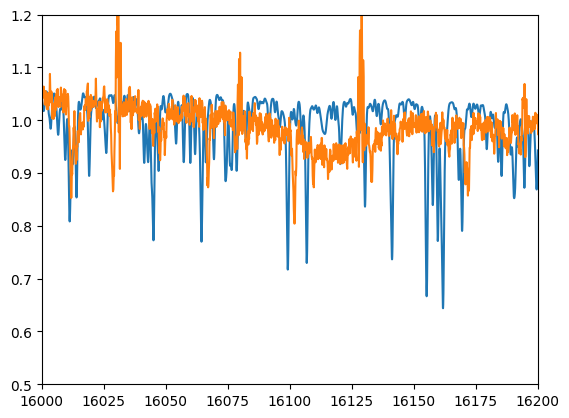

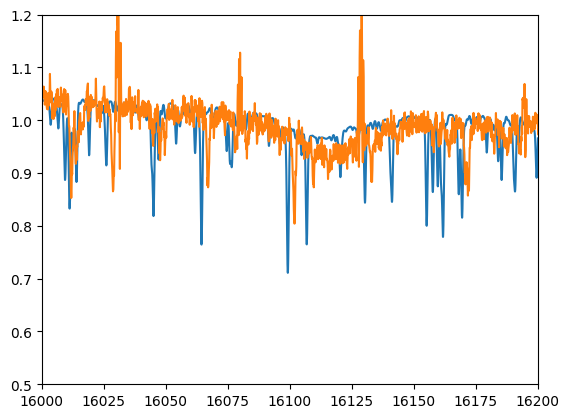

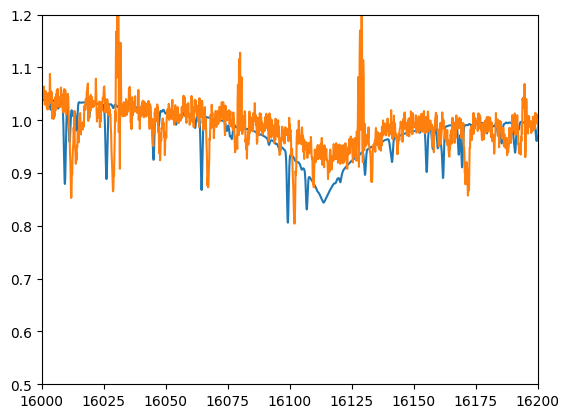

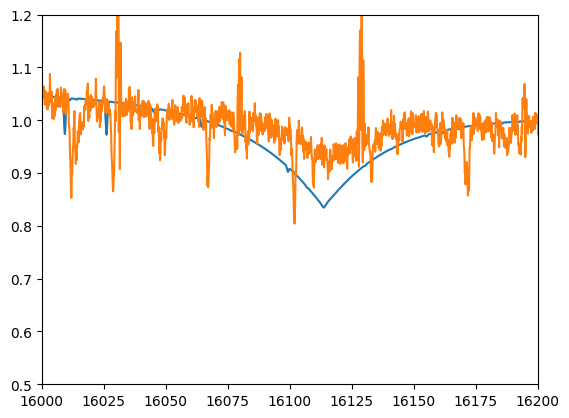

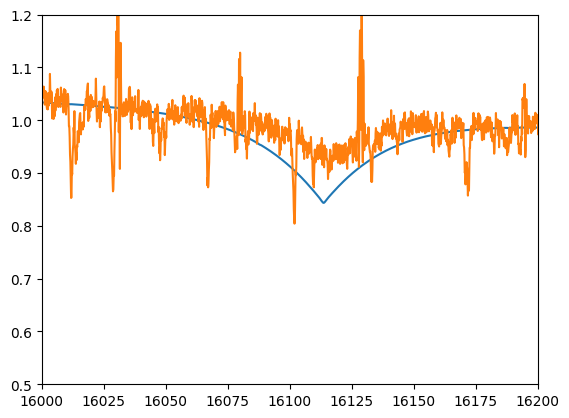

In [96]:
a,b=16000,16200
plt.plot(wavelength,m_template_broad/np.median(m_template_broad))
plt.plot(wave,flux/np.median(flux))
plt.xlim(a,b)
plt.ylim(0.5,1.2)
plt.show()
plt.plot(wavelength,k_template_broad/np.median(k_template_broad))
plt.plot(wave,flux/np.median(flux))
plt.xlim(a,b)
plt.ylim(0.5,1.2)
plt.show()
plt.plot(wavelength,g_template_broad/np.median(g_template_broad))
plt.plot(wave,flux/np.median(flux))
plt.xlim(a,b)
plt.ylim(0.5,1.2)
plt.show()
plt.plot(wavelength,f_template_broad/np.median(f_template_broad))
plt.plot(wave,flux/np.median(flux))
plt.xlim(a,b)
plt.ylim(0.5,1.2)
plt.show()
plt.plot(wavelength,a_template_broad/np.median(a_template_broad))
plt.plot(wave,flux/np.median(flux))
plt.xlim(a,b)
plt.ylim(0.5,1.2)
plt.show()
plt.plot(wavelength,b_template_broad/np.median(b_template_broad))
plt.plot(wave,flux/np.median(flux))
plt.xlim(a,b)
plt.ylim(0.5,1.2)
plt.show()

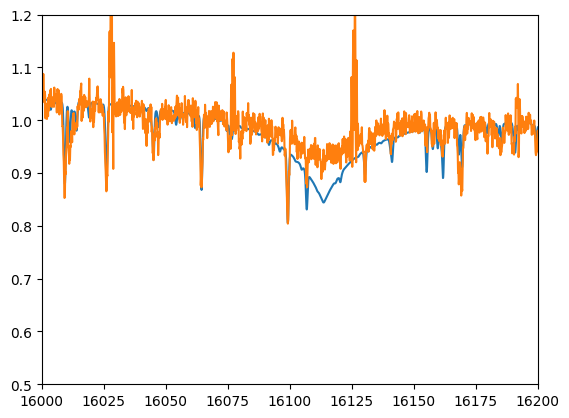

In [106]:
v=-50
plt.plot(wavelength,f_template_broad/np.median(f_template_broad))
plt.plot(wave+wave*v/3e5,flux/np.median(flux))
plt.xlim(a,b)
plt.ylim(0.5,1.2)
plt.show()

#### Question
- What spectral type is this object appears to be?
- How do you know?
- Is the object blueshifted or redshifted?
- What is the radial velocity of the source?
- What is the threshold of confidence on this RV (i.e., by which value do you need to offset your best RV before the offset becomes too significant)

#### Answer